In [2]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch
%matplotlib inline

In [3]:
from utils import load_mnist,get_encoder_hidden_size
from model import AutoEncoder

In [4]:
device =torch.device('cuda')  if torch.cuda.is_available() else torch.device('cpu')

In [5]:
def load(fn,device):
    d = torch.load('./model.pth',map_location=device)
    model = d['model']
    config = d['config']
    return model , config

In [6]:
def show_image(x):
    if x.dim() == 1:
        x = x.reshape(int(x.shape[0]**.5),-1)

    plt.imshow(x,cmap='gray')
    plt.show()

In [7]:
x,y = load_mnist(is_train=False,flatten=True)
input_size = x.shape[-1]
output_size = x.shape[-1]
model_dict , config = load('./model.pth',device=device)

model = AutoEncoder(input_size=input_size,
                    output_size=output_size,
                    hidden_sizes=get_encoder_hidden_size(config.n_layers),
                    btl_size=config.btl_size,)

model.load_state_dict(model_dict)

<All keys matched successfully>

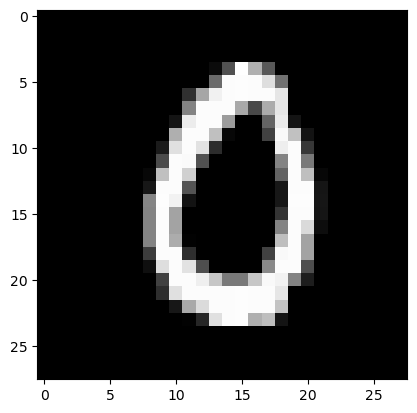

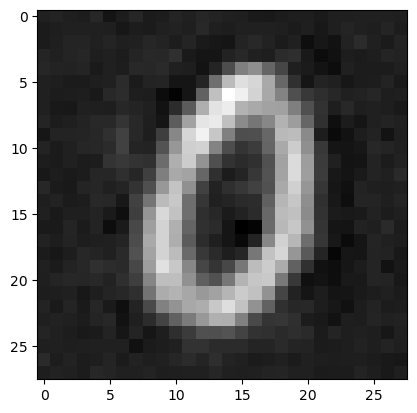

In [8]:
model.eval()

with torch.no_grad():
    import random
    
    index = int(random.random() * x.shape[0])

    recon = model(x[index].reshape(1,-1)).squeeze()

    show_image(x[index])
    show_image(recon)

## Manifold - Compare High-Dimension and Low Manifolds

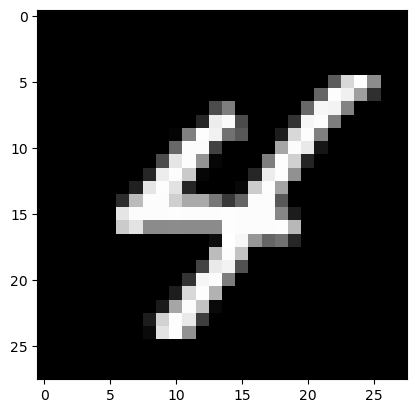

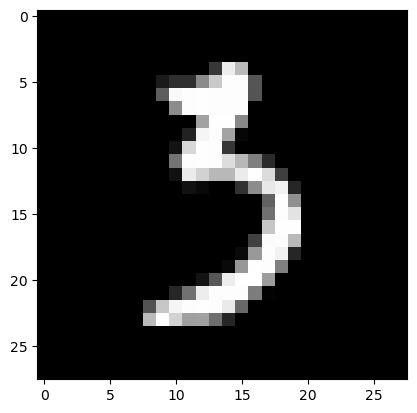

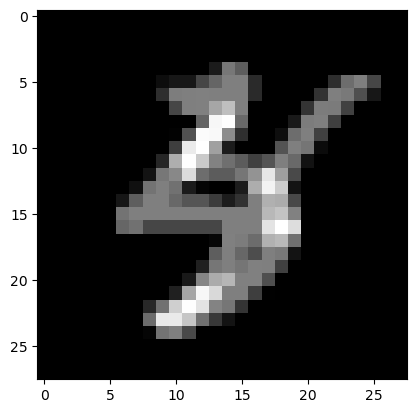

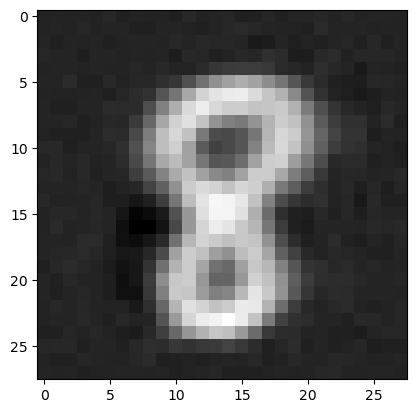

In [17]:
model.eval()

with torch.no_grad():
    import random

    z1_index = int(random.random() * x.shape[0])
    z2_index = int(random.random()*x.shape[0])

    z1 = model.encoder(x[z1_index].reshape(1,-1))
    z2 = model.encoder(x[z2_index].reshape(1,-1))

    recon = model.decoder(((z1+z2)/2).reshape(1,-1)).squeeze()

    show_image(x[z1_index])
    show_image(x[z2_index])
    show_image((x[z1_index]+x[z2_index])/2)
    show_image(recon)

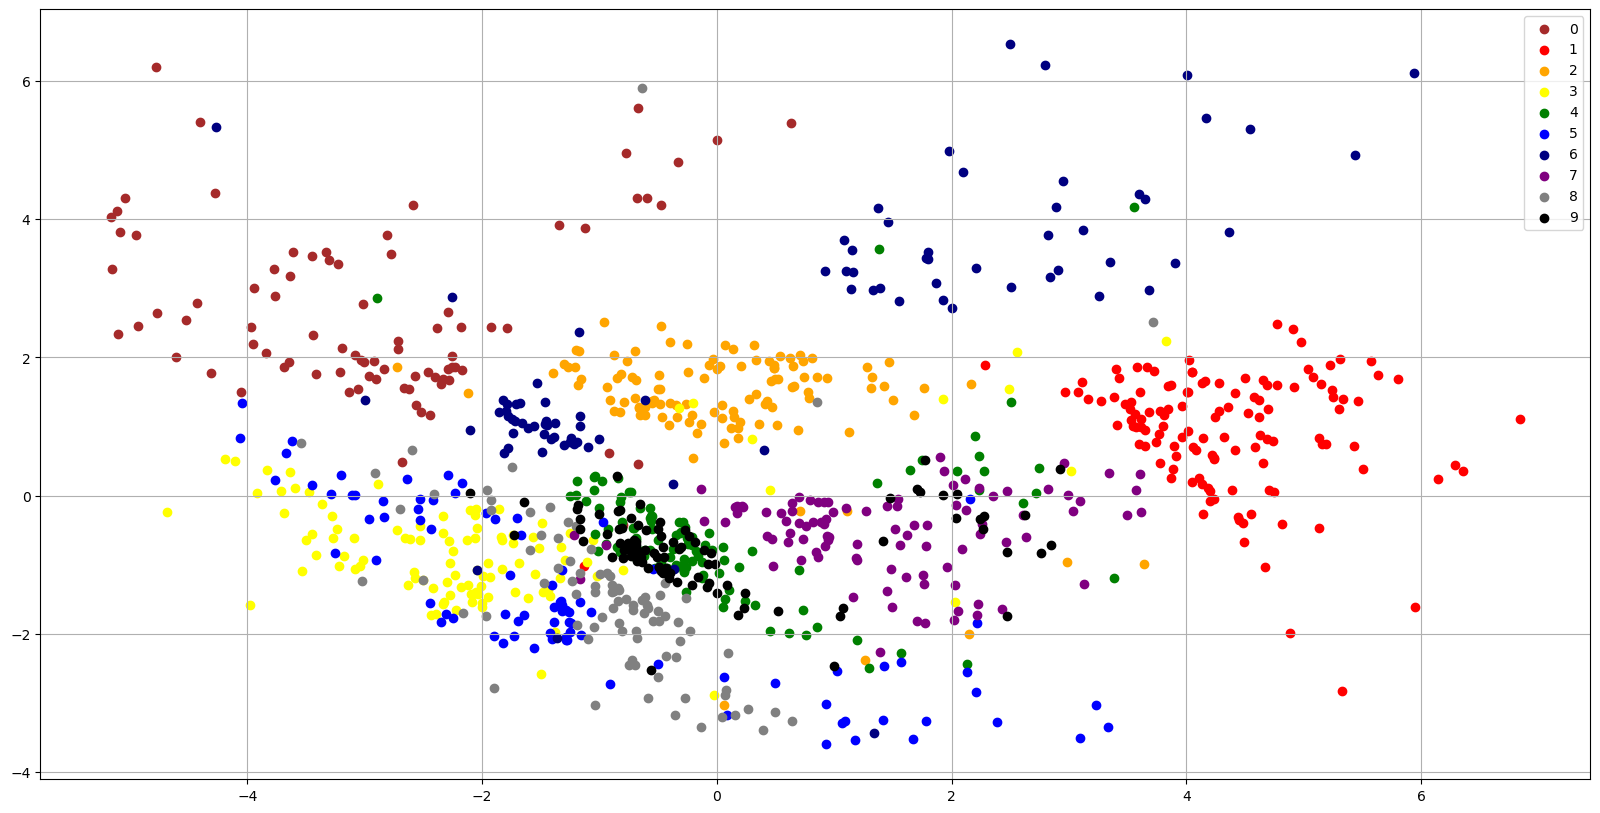

In [10]:
if config.btl_size == 2:
    color_map = [
        'brown','red','orange','yellow','green','blue',
        'navy','purple','gray','black',
    ]

plt.figure(figsize=(20,10))
with torch.no_grad():
    latents = model.encoder(x[:1000])

    for i in range(10):
        target_latents = latents[y[:1000]==i]
        target_y = y[:1000][y[:1000]==i]
        plt.scatter(target_latents[:,0],
                    target_latents[:,1],
                    marker='o',
                    color=color_map[i],
                    label=i)
    plt.legend()
    plt.grid(axis='both')
    plt.show()

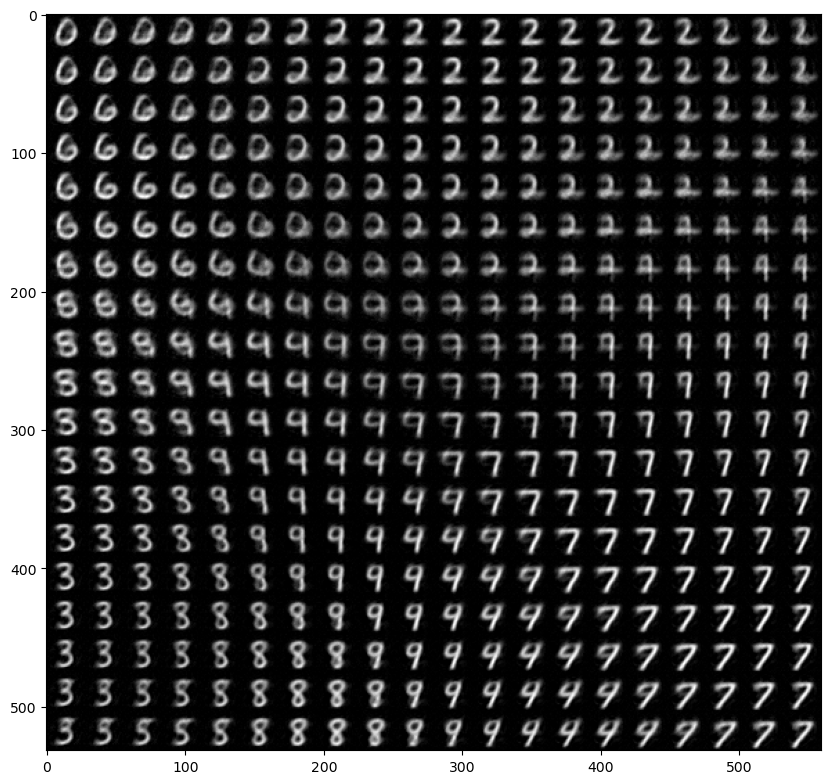

In [11]:
if config.btl_size ==2:
    min_range ,max_range = -2.,2. 
    n = 20
    step = (max_range - min_range) / float(n)

    with torch.no_grad():
        lines=[]
        
        for v1 in np.arange(min_range,max_range,step):
            z = torch.stack([
                torch.FloatTensor([v1]*n),
                torch.FloatTensor([v2 for v2 in np.arange(min_range,max_range,step)])
            ],dim=-1)
            
            line = torch.clamp(model.decoder(z).reshape(n,28,28),0,1)
            line = torch.cat([line[i] for i in range(n-1,0,-1)],dim=0)

            lines += [line]

        lines = torch.cat(lines,dim=-1)
        plt.figure(figsize=(10,10))
        show_image(lines)